In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from joblib import dump, load

# RNN & LSTM Imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential


In [3]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = roc_curve(target, predictions)
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [4]:
df = pd.read_csv('./datasets/test_filtered_data.csv')

In [5]:
embedding_dim = 300    # Dimensions used for glove6b100
max_length = 100   # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(df)
test_portion=.2

In [6]:
comments = df['comment_text']
# y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'isToxic']]
y = df['toxic']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(comments, y, test_size=test_portion)

In [8]:
# y_train_isToxic = y_train['isToxic']
# y_train = y_train.drop(columns=['isToxic'])

# y_test_isToxic = y_test['isToxic']
# y_test = y_test.drop(columns=['isToxic'])

In [9]:
tokenizer = Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    oov_token=oov_tok,
)

In [10]:
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)


In [11]:
sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [12]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
word_index = tokenizer.word_index
vocab_size = len(word_index)

print(vocab_size)

48207


In [27]:
from sklearn.utils import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
sample_weights[y_train == 1] *= 1.5

In [15]:

embeddings_index = {}
f = open('./Glove/glove.840B.300d.txt','r',encoding='utf-8')
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2196016 word vectors.


In [16]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [28]:
from tensorflow.keras.layers import SpatialDropout1D, GRU, Dropout, BatchNormalization, Dense, Embedding
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from keras import backend as K
import tensorflow as tf


input_dimension = input_dimension

# Input Layer
input_layer = Input(shape=(max_length,))

# Embedding Layer
embedding_layer = Embedding(input_dimension, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)
spatial_dropout = SpatialDropout1D(0.3)(embedding_layer)

# GRU Layer
gru_layer = Bidirectional(GRU(300, return_sequences=True))(spatial_dropout)
dropout_layer_2 = Dropout(0.5)(gru_layer)
batch_norm_layer_2 = BatchNormalization()(dropout_layer_2)

# Attention Layer
attention_layer = Attention()([batch_norm_layer_2, batch_norm_layer_2])
dropout_layer_3 = Dropout(0.5)(attention_layer)
batch_norm_layer_3 = BatchNormalization()(dropout_layer_3)

# Flatten Layer
flatten_layer = Flatten()(batch_norm_layer_3)

# Dense Layers
dense_layer_1 = Dense(32, activation='relu')(flatten_layer)
dropout_layer_1 = Dropout(0.5)(dense_layer_1)
batch_norm_layer_1 = BatchNormalization()(dropout_layer_1)

dense_layer_2 = Dense(16, activation='relu')(batch_norm_layer_1)
dropout_layer_4 = Dropout(0.5)(dense_layer_2)
batch_norm_layer_4 = BatchNormalization()(dropout_layer_4)

output_layer = Dense(1, activation='sigmoid')(batch_norm_layer_4)

# Compile model
model = Model(inputs=input_layer, outputs=output_layer)


model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Créez une instance de ModelCheckpoint
checkpoint = ModelCheckpoint('gru.h5',  # chemin du fichier où sauvegarder le modèle
                             monitor='val_loss',  # quelle métrique à surveiller
                             verbose=0, 
                             save_best_only=True,  # ne sauvegarder que le meilleur modèle
                             mode='auto')  # 'auto' signifie que la direction est déterminée automatiquement à partir du nom de la métrique surveillée

# sample_weights = sample_weights.astype('float32')

history = model.fit(
        padded_sequences, 
        y_train, 
        epochs=10, 
        validation_data=(test_padded_sequences, y_test),
        sample_weight=sample_weights,
        batch_size=32,
        callbacks=[checkpoint]
    )

print("Training Complete")

# poids fichier de checkpoint
model.load_weights('gru.h5')




Epoch 1/10


W0000 00:00:1710461566.734336       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


375/375 [==============================] - ETA: 0s - loss: 0.6035 - accuracy: 0.6690

W0000 00:00:1710461584.278948       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


375/375 [==============================] - 21s 50ms/step - loss: 0.6035 - accuracy: 0.6690 - val_loss: 0.6373 - val_accuracy: 0.7733
Epoch 2/10


/Users/antoine/miniconda3/envs/AI/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 18s 47ms/step - loss: 0.4253 - accuracy: 0.8261 - val_loss: 0.4683 - val_accuracy: 0.8686
Epoch 3/10
375/375 [==============================] - 17s 45ms/step - loss: 0.3457 - accuracy: 0.8536 - val_loss: 0.7763 - val_accuracy: 0.5375
Epoch 4/10
375/375 [==============================] - 17s 45ms/step - loss: 0.3134 - accuracy: 0.8879 - val_loss: 0.2038 - val_accuracy: 0.9637
Epoch 5/10
375/375 [==============================] - 17s 45ms/step - loss: 0.2940 - accuracy: 0.8942 - val_loss: 0.2465 - val_accuracy: 0.9530
Epoch 6/10
375/375 [==============================] - 17s 45ms/step - loss: 0.2729 - accuracy: 0.9017 - val_loss: 0.2031 - val_accuracy: 0.9507
Epoch 7/10
375/375 [==============================] - 17s 45ms/step - loss: 0.2708 - accuracy: 0.8976 - val_loss: 0.1661 - val_accuracy: 0.9623
Epoch 8/10
375/375 [==============================] - 17s 45ms/step - loss: 0.2391 - accuracy: 0.9083 - val_loss: 0.1719 - val_accuracy: 0.9533
Epo

In [19]:
# # Batch Sizes Annealing


# # Définir les tailles de batch initiale et finale
# initial_batch_size = 0
# final_batch_size = 5
# batch_sizes = [ 8, 16 , 32, 64, 128, 256]

# # Définir le nombre total d'époques
# total_epochs = 10

# # Boucle sur les époques
# for epoch in range(total_epochs):
#     # Calculer la taille du batch pour cette époque
#     index = initial_batch_size + epoch * (final_batch_size - initial_batch_size) / total_epochs

#     # Convertir la taille du batch en un entier, car elle doit être un nombre entier
#     batch_size = batch_sizes[int(index)]

#     # Entraîner le modèle pour une époque avec la taille de batch actuelle
#     history = model.fit(
#         padded_sequences, 
#         y_train, 
#         epochs=1, 
#         validation_data=(test_padded_sequences, y_test),
#         sample_weight=sample_weights,
#         batch_size=batch_size,
#         callbacks=[checkpoint]
#     )

# print("Training Complete")

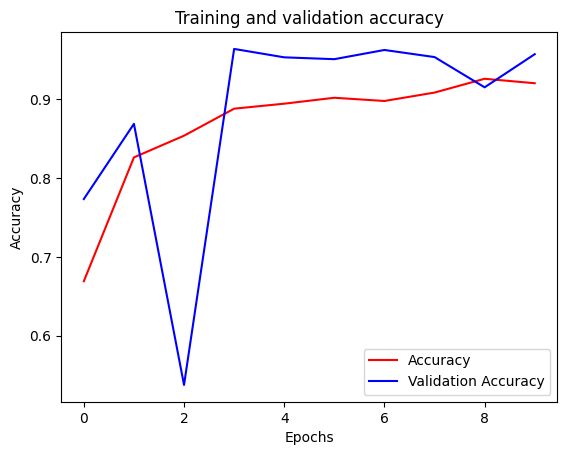

<Figure size 640x480 with 0 Axes>

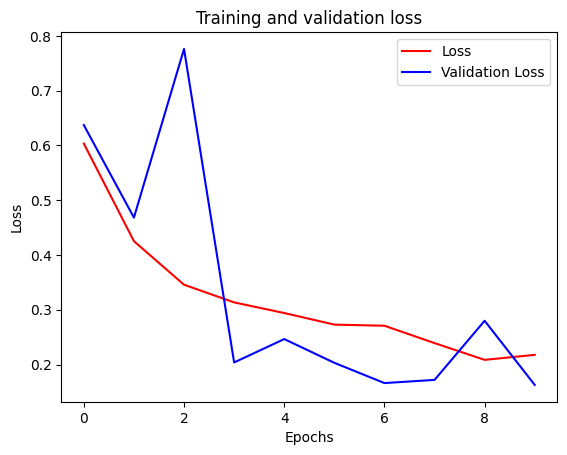

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Vos prédictions et vraies valeurs
y_pred = model.predict(test_padded_sequences)
y_true = y_test

print(f"Auc: {roc_auc(y_pred, y_true)} ")

# Arrondir les prédictions
y_pred = y_pred.round()


# Calcul de la précision
precision = precision_score(y_true, y_pred)

# Calcul du rappel
recall = recall_score(y_true, y_pred)

# Calcul du score F1
f1 = f1_score(y_true, y_pred)

print(f"Matrice de confusion : {confusion_matrix(y_test, y_pred)}")
print(f"Précision : {precision}")
print(f"Rappel : {recall}")
print(f"Score F1 : {f1}")


W0000 00:00:1710461760.849709       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


94/94 [==============================] - 2s 16ms/step
Auc: 0.9729050113081775 
Matrice de confusion : [[2671   57]
 [  72  199]]
Précision : 0.77734375
Rappel : 0.7343173431734318
Score F1 : 0.7552182163187856


In [22]:
# from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import multilabel_confusion_matrix


# # Vos prédictions et vraies valeurs
# y_pred = model.predict(test_padded_sequences)
# y_true = y_test

# # Arrondir les prédictions
# y_pred = y_pred.round()

# # Calcul de la précision
# precision = precision_score(y_true, y_pred, average='weighted') # ou 'macro' ou 'weighted'

# # Calcul du rappel
# recall = recall_score(y_true, y_pred, average='weighted') # ou 'macro' ou 'weighted'

# # Calcul du score F1
# f1 = f1_score(y_true, y_pred, average='weighted') # ou 'macro' ou 'weighted'

# # Calcul de la matrice de confusion multilabel
# multilabel_cm = multilabel_confusion_matrix(y_true, y_pred)

# # Affichage de la matrice de confusion pour chaque label
# for i, matrix in enumerate(multilabel_cm):
#     print(f"Matrice de confusion pour le label {i} :")
#     print(matrix)
# print(f"Précision : {precision}")
# print(f"Rappel : {recall}")
# print(f"Score F1 : {f1}")